In [1]:
import ee
import geopandas as gpd
import numpy as np
import pandas as pd

import agrigee_lite as agl

np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)
pd.set_option('display.float_format', '{:.2f}'.format)

# pandas show all columns
pd.set_option('display.max_columns', None)

In [2]:
ee.Initialize(opt_url="https://earthengine-highvolume.googleapis.com", project="ee-paulagibrim")

In [4]:
gdf = gpd.read_parquet("data/mt_crops.parquet")
gdf["start_date"] = pd.to_datetime(gdf.year.apply(lambda x: f"{x-1}-10-01"))
gdf["end_date"] = pd.to_datetime(gdf.year.apply(lambda x: f"{x}-10-01"))

In [5]:
row = gdf.iloc[50]

print(row)

varda_id                   01911f59-27ba-7c52-a3a0-d044ffe357c1
ha                                                       500.80
geometry      POLYGON ((-55.94728879741619 -12.4627626790059...
crops                                                        39
percentage                                                 1.00
year                                                       2020
crop_name                                               Soybean
start_date                                  2019-10-01 00:00:00
end_date                                    2020-10-01 00:00:00
Name: 50, dtype: object


In [6]:
sat_opt = agl.sat.Modis()

In [14]:
from ee_s1_ard import S1ARDImageCollection

In [7]:
images = agl.get.images(row.geometry, row.start_date, row.end_date, sat_opt)

Downloading: 100%|██████████| 239/239 [01:08<00:00,  3.48it/s]


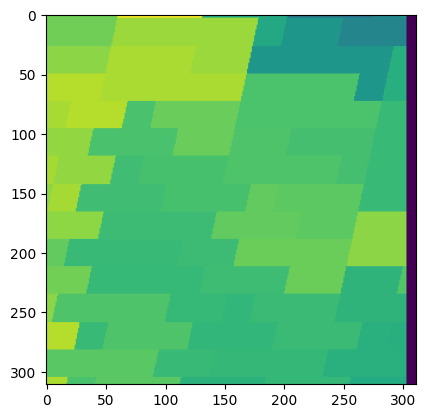

In [13]:
# First band is RED, second is NIR
import matplotlib.pyplot as plt

plt.imshow(images[0, :, :, 1])

In [ ]:
sat_opt = agl.sat.Modis()

agl.vis.sits(row.geometry, row.start_date, row.end_date, sat_opt, "evi2")

In [ ]:
agl.get.sits(row.geometry, row.start_date, row.end_date, sat_opt)

In [ ]:

agl.get.images(row.geometry, row.start_date, row.end_date, sat_opt)

In [ ]:
sat = agl.sat.Landsat5()

images = agl.get.images(row.geometry, "1990-10-01", "2000-10-01", sat)

In [ ]:
sat = agl.sat.Landsat4()

agl.vis.sits(row.geometry, "1990-10-01", "2000-10-01", sat, "evi2")

In [ ]:
sat = agl.sat.Landsat7()

agl.vis.sits(row.geometry, row.start_date, row.end_date, sat, "evi2")

In [ ]:
sat_opt = agl.sat.Sentinel2()

agl.vis.sits(row.geometry, row.start_date, row.end_date, sat_opt, "evi2")

In [ ]:
sat_opt = agl.sat.Landsat8()

agl.vis.sits(row.geometry, row.start_date, row.end_date, sat_opt, "evi2")

In [ ]:
sat_opt = agl.sat.Landsat9()

agl.vis.sits(row.geometry, "2023-10-01", "2025-10-01", sat_opt, "evi2")

In [ ]:
agl.get.sits(row.geometry, "1995-10-01", "1997-10-01", sat)

In [ ]:
sat = agl.sat.Sentinel1(ascending=False)

agl.vis.sits(row.geometry, row.start_date, row.end_date, sat, "vhvv")

In [ ]:
sat = agl.sat.Sentinel2()

agl.get.sits(row.geometry, row.start_date, row.end_date, sat, date_types=["fyear"])

In [ ]:
agl.get.sits(row.geometry, row.start_date, row.end_date, sat, date_types=["fyear"])

In [ ]:
images = agl.get.images(row.geometry, row.start_date, row.end_date, sat)

In [ ]:
results = images[:, :, :, 1]/ images[:, :, :, 0]
# results[np.isnan(results)] = 0

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
np.percentile(results, 90)

In [ ]:
plt.imshow(results[65, :, :], cmap="PRGn", vmin=1.5, vmax=2.3)

plt.colorbar()
plt.show()

In [ ]:
sampled_gdf = gdf.sample(5000, random_state=42).reset_index(drop=True)

In [ ]:
sampled_gdf.rename(columns={"year": "0"})["0"]

In [ ]:
row = gdf.iloc[0]

In [ ]:
agl.get.images(row.geometry, )

In [ ]:
satellite = agl.sat.Sentinel2()

In [ ]:
features = agl.get.multiple_sits(sampled_gdf, satellite)

In [ ]:
sampled_gdf_f = sampled_gdf.merge(features, right_index=True, left_index=True)

In [ ]:
from agrigee_lite.misc import wide_to_long_dataframe

In [ ]:
def wide_to_long_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["indexnum"] = range(len(df))
    df_long = df.melt(id_vars=["indexnum"], var_name="band_time", value_name="value")

    df_long[["prefix", "band", "idx"]] = df_long["band_time"].str.extract(r"([^_]+)_(\w+)_(\d+)")

    df_long["idx"] = df_long["idx"].astype(int)
    df_long["value"] = pd.to_numeric(df_long["value"], errors="coerce")

    df_pivot = df_long.pivot(index=["indexnum", "idx"], columns="band", values="value").reset_index()
    df_pivot.sort_values(by=["indexnum", "idx"], inplace=True)
    df_pivot = df_pivot.drop(columns=["idx"])
    df_pivot.columns.name = None

    df_pivot.dropna(inplace=True)
    df_pivot = df_pivot[df_pivot.doy!=0].reset_index(drop=True)

    return df_pivot

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from agrigee_lite.misc import compute_index_from_df

In [ ]:
from agrigee_lite.numpy_indices import ALL_NUMPY_INDICES

In [ ]:
sampled_gdf_f.crop_name.value_counts()

In [ ]:
grass = sampled_gdf_f[sampled_gdf_f.crop_name=="Almonds"].sample(1000, replace=True).reset_index(drop=True).drop(columns=["geometry", "year", "start_date", "end_date", "crop_name",  "centroid_x", "centroid_y", "cluster_id"])

# grass_feature = agl.get.multiple_sits(grass, satellite, force_redownload=True)

grass_feature_long = wide_to_long_dataframe(grass)

fig, ax = plt.subplots(1, figsize=(20, 10))

for indexx in sorted(grass_feature_long.indexnum.unique().tolist()):
    long_sits = grass_feature_long[grass_feature_long.indexnum==indexx].reset_index(drop=True).copy()
    band_or_indice_to_plot = "evi2"

    if band_or_indice_to_plot in ALL_NUMPY_INDICES:
        y = compute_index_from_df(long_sits/10000, ALL_NUMPY_INDICES[band_or_indice_to_plot])
    else:
        y = long_sits[band_or_indice_to_plot].values

    ax.plot(long_sits.doy, y, color="green", alpha=0.1)

plt.xlim(0, 366)
plt.ylim(-0.1, 1.1)
plt.show()

In [ ]:
grass

In [ ]:
gdf.crop_name.unique()

In [ ]:
grass = gdf[gdf.crop_name=='Corn'].sample(1000).reset_index(drop=True)

grass_feature = agl.get.multiple_sits(grass, satellite, force_redownload=True)

grass_feature_long = wide_to_long_dataframe(grass_feature)

fig, ax = plt.subplots(1, figsize=(20, 10))

for indexx in sorted(grass_feature_long.indexnum.unique().tolist()):
    long_sits = grass_feature_long[grass_feature_long.indexnum==indexx].reset_index(drop=True).copy()
    band_or_indice_to_plot = "evi2"

    if band_or_indice_to_plot in ALL_NUMPY_INDICES:
        y = compute_index_from_df(long_sits/10000, ALL_NUMPY_INDICES[band_or_indice_to_plot])
    else:
        y = long_sits[band_or_indice_to_plot].values

    ax.plot(long_sits.doy, y, color="green", alpha=0.1)

plt.xlim(0, 366)
plt.ylim(-0.1, 1.1)
plt.show()

In [ ]:
agl.get.multiple_sits(gdf, satellite, force_redownload=True)

In [ ]:
from agrigee_lite.get.sits import download_multiple_sits

In [ ]:
download_multiple_sits(gdf.iloc[5:10].reset_index(), satellite)

In [ ]:
download_multiple_sits(gdf.iloc[5:10].reset_index(), satellite)

In [ ]:
agl.get.multiple_sits(gdf.sample(500, random_state=42).reset_index(), satellite, force_redownload=True)

In [ ]:
agl.get.multiple_sits(gdf.sample(500, random_state=42).reset_index(), satellite, force_redownload=True)

In [ ]:
sampled_gdf = gdf.sample(20000, random_state=42).reset_index(drop=True).copy()

In [ ]:
agl.get.multiple_sits(sampled_gdf, satellite)

In [ ]:
row = gdf.iloc[249766]
print(row)

agl.vis.sits(row.geometry, row.start_date, row.end_date, satellite, "evi2")

In [ ]:
row = gdf.iloc[1]
print(row)

agl.vis.sits(row.geometry, row.start_date, row.end_date, satellite, "evi2")